<a href="https://colab.research.google.com/github/ArunK-ML/Project---Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
!pip install tensorflow>=2.9.0 scikit-learn matplotlib pillow streamlit numpy

# **Data Load**

In [2]:
# ========================================
# STEP 1: Import libraries
# ========================================
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [3]:
# ========================================
# STEP 2: Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ========================================
# STEP 3: Set dataset paths
# (update if your path is different)
# ========================================
DATASET_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour"
TRAIN_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train"
TEST_DIR  = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/test"
VALID_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/valid"


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define data preprocessing for validation and test images
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(150, 150), # Adjust target size as needed
                                              batch_size=32,
                                              class_mode='categorical')

valid_gen = valid_test_datagen.flow_from_directory(VALID_DIR,
                                                   target_size=(150, 150), # Adjust target size as needed
                                                   batch_size=32,
                                                   class_mode='categorical')

test_gen = valid_test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(150, 150), # Adjust target size as needed
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [6]:
import os

for split in ["train", "valid", "test"]:
    folder = os.path.join(DATASET_DIR, split)
    print(f"\n--- {split.upper()} ---")
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            print(f"{cls:15s} -> {len(os.listdir(cls_path))} images")



--- TRAIN ---
no_tumor        -> 335 images
pituitary       -> 438 images
meningioma      -> 358 images
glioma          -> 564 images

--- VALID ---
glioma          -> 161 images
no_tumor        -> 99 images
meningioma      -> 124 images
pituitary       -> 118 images

--- TEST ---
pituitary       -> 54 images
no_tumor        -> 49 images
glioma          -> 80 images
meningioma      -> 63 images


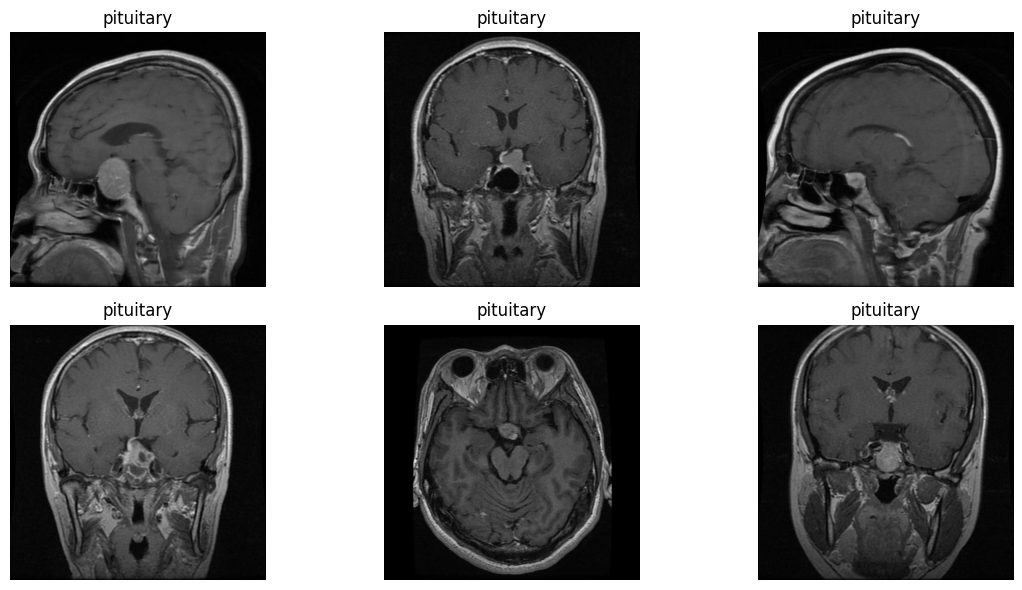

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

SPLIT = "train"  # change to "valid" or "test"

# Filter out non-directory entries before choosing a class
valid_classes = [cls for cls in os.listdir(os.path.join(DATASET_DIR, SPLIT)) if os.path.isdir(os.path.join(DATASET_DIR, SPLIT, cls))]
CLASS = random.choice(valid_classes)
IMG_DIR = os.path.join(DATASET_DIR, SPLIT, CLASS)

images = random.sample(os.listdir(IMG_DIR), 6)  # pick 6 random images

plt.figure(figsize=(12,6))
for i, img_name in enumerate(images):
    img_path = os.path.join(IMG_DIR, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(CLASS)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# ========================================
# STEP 4: Data Generators (with Augmentation)
# ========================================

# Define image size and batch size
IMG_SIZE = (224, 224) # You can adjust this as needed
BATCH_SIZE = 32 # You can adjust this as needed

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.8,1.2)
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

class_indices = train_gen.class_indices
print("Class indices:", class_indices)

# Save class mapping
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


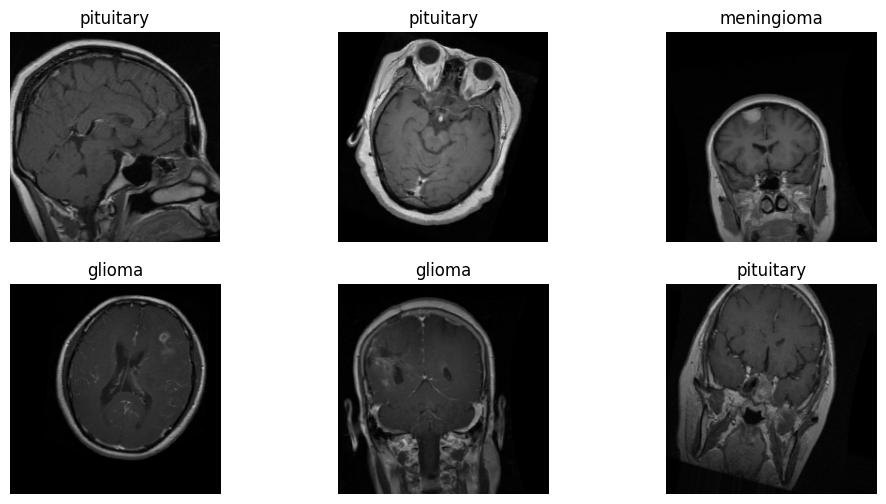

In [10]:
# ========================================
# STEP 5: Visualize Sample Images
# ========================================
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    label = list(train_gen.class_indices.keys())[y_batch[i].argmax()]
    plt.title(label)
    plt.axis("off")
plt.show()


In [ ]:
# ========================================
# STEP 6: Build Custom CNN
# ========================================
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="custom_cnn")
    return model

num_classes = train_gen.num_classes
custom_model = build_custom_cnn(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
custom_model.summary()


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,684 (436.27 KB)

 Trainable params: 110,980 (433.52 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# ========================================
# STEP 7: Train Custom CNN
# ========================================
custom_model.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

cb = [
    callbacks.ModelCheckpoint("custom_cnn_best.h5", save_best_only=True, monitor="val_loss", verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history_custom = custom_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=cb)
custom_model.save("custom_cnn_final.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5318 - loss: 1.2483
Epoch 1: val_loss improved from inf to 1.36948, saving model to custom_cnn_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 517s 10s/step - accuracy: 0.5331 - loss: 1.2449 - val_accuracy: 0.2351 - val_loss: 1.3695 - learning_rate: 0.0010
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6894 - loss: 0.8326
Epoch 2: val_loss did not improve from 1.36948
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 670ms/step - accuracy: 0.6891 - loss: 0.8329 - val_accuracy: 0.2351 - val_loss: 1.4844 - learning_rate: 0.0010
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6818 - loss: 0.8324
Epoch 3: val_loss did not improve from 1.36948
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.6817 - loss: 0.8325 - val_accuracy: 0.2749 - val_loss: 1.4857 - learning_rate: 0.0010
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.6837 - loss: 0.8207
Epoch 4: val_loss did not improve from 1.36948

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 648ms/step - accuracy: 0.6838 - loss: 0.8205 - val_accuracy: 0.2351 

In [ ]:
# ========================================
# STEP 8: Transfer Learning (EfficientNetB0)
# ========================================
def build_tl_model(input_shape=(224,224,3), num_classes=4):
    base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=base.input, outputs=out, name="effnetb0_tl")
    return model, base

tl_model, base_model = build_tl_model(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "effnetb0_tl"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ========================================
# STEP 9: Train Transfer Learning
# ========================================
tl_model.compile(optimizer=optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

cb_tl = [
    callbacks.ModelCheckpoint("tl_best.h5", save_best_only=True, monitor="val_loss", verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]

history_tl = tl_model.fit(train_gen, validation_data=val_gen, epochs=8, callbacks=cb_tl)

# Fine-tune
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

tl_model.compile(optimizer=optimizers.Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
history_tl_fine = tl_model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=cb_tl)

tl_model.save("tl_effnetb0_final.h5")


Epoch 1/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.2924 - loss: 1.4020
Epoch 1: val_loss improved from inf to 1.38041, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2925 - loss: 1.4018 - val_accuracy: 0.3207 - val_loss: 1.3804 - learning_rate: 0.0010
Epoch 2/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3007 - loss: 1.3749
Epoch 2: val_loss improved from 1.38041 to 1.37264, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 639ms/step - accuracy: 0.3006 - loss: 1.3750 - val_accuracy: 0.3207 - val_loss: 1.3726 - learning_rate: 0.0010
Epoch 3/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.3240 - loss: 1.3845
Epoch 3: val_loss did not improve from 1.37264
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 783ms/step - accuracy: 0.3238 - loss: 1.3844 - val_accuracy: 0.3207 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 4/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3415 - loss: 1.3674
Epoch 4: val_loss improved from 1.37264 to 1.37238, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 633ms/step - accuracy: 0.3413 - loss: 1.3674 - val_accuracy: 0.3207 - val_loss: 1.3724 - learning_rate: 0.0010
Epoch 5/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3190 - loss: 1.3721
Epoch 5: val_loss improved from 1.37238 to 1.37196, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - accuracy: 0.3193 - loss: 1.3721 - val_accuracy: 0.3207 - val_loss: 1.3720 - learning_rate: 0.0010
Epoch 6/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3317 - loss: 1.3739
Epoch 6: val_loss did not improve from 1.37196
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.3317 - loss: 1.3738 - val_accuracy: 0.3207 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 7/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.3386 - loss: 1.3601
Epoch 7: val_loss did not improve from 1.37196
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 651ms/step - accuracy: 0.3384 - loss: 1.3602 - val_accuracy: 0.3207 - val_loss: 1.3733 - learning_rate: 0.0010
Epoch 8/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.3397 - loss: 1.3668
Epoch 8: val_loss did not improve from 1.37196

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.3396 - loss: 1.3668 - val_accuracy: 0.3207 - 

53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.2421 - loss: 1.4482 - val_accuracy: 0.3207 - val_loss: 1.3719 - learning_rate: 1.0000e-05
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.2941 - loss: 1.3871
Epoch 2: val_loss improved from 1.37188 to 1.37152, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 634ms/step - accuracy: 0.2941 - loss: 1.3871 - val_accuracy: 0.3207 - val_loss: 1.3715 - learning_rate: 1.0000e-05
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.3169 - loss: 1.3844
Epoch 3: val_loss improved from 1.37152 to 1.37034, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 665ms/step - accuracy: 0.3168 - loss: 1.3845 - val_accuracy: 0.3207 - val_loss: 1.3703 - learning_rate: 1.0000e-05
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3183 - loss: 1.3825
Epoch 4: val_loss improved from 1.37034 to 1.36928, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 622ms/step - accuracy: 0.3184 - loss: 1.3824 - val_accuracy: 0.3207 - val_loss: 1.3693 - learning_rate: 1.0000e-05
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.3414 - loss: 1.3620
Epoch 5: val_loss did not improve from 1.36928
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.3411 - loss: 1.3621 - val_accuracy: 0.3207 - val_loss: 1.3697 - learning_rate: 1.0000e-05
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3331 - loss: 1.3636
Epoch 6: val_loss did not improve from 1.36928
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 593ms/step - accuracy: 0.3331 - loss: 1.3638 - val_accuracy: 0.3207 - val_loss: 1.3695 - learning_rate: 1.0000e-05
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.3298 - loss: 1.3578
Epoch 7: val_loss improved from 1.36928 to 1.36837, saving model to tl_best.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - accuracy: 0.3294 - loss: 1.3580 - val_accuracy: 0.3207 - val_loss: 1.3684 - learning_rate: 1.0000e-05
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3027 - loss: 1.3794
Epoch 8: val_loss did not improve from 1.36837
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - accuracy: 0.3031 - loss: 1.3792 - val_accuracy: 0.3207 - val_loss: 1.3706 - learning_rate: 1.0000e-05
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.3404 - loss: 1.3589
Epoch 9: val_loss did not improve from 1.36837
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 621ms/step - accuracy: 0.3403 - loss: 1.3590 - val_accuracy: 0.3207 - val_loss: 1.3699 - learning_rate: 1.0000e-05
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.3318 - loss: 1.3539
Epoch 10: val_loss did not improve from 1.36837

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - accuracy: 0.3319 - loss: 1.3540 - val_a

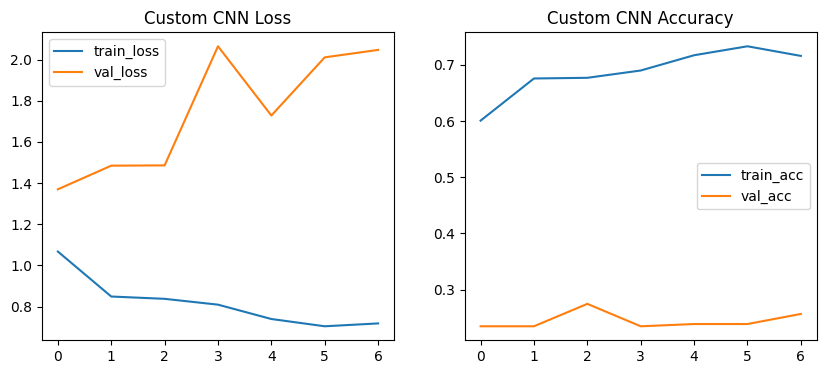

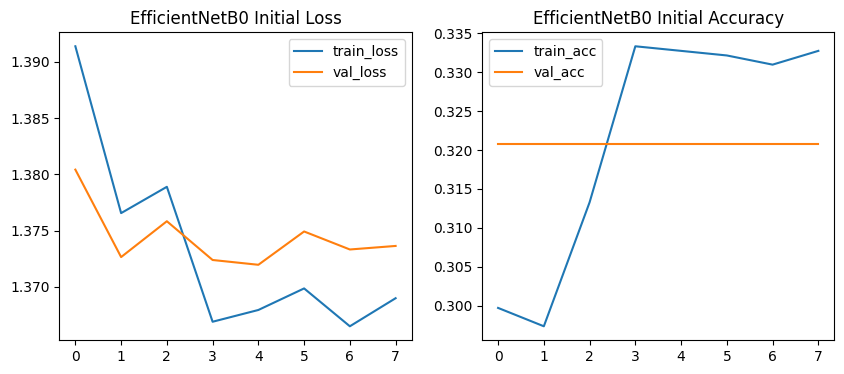

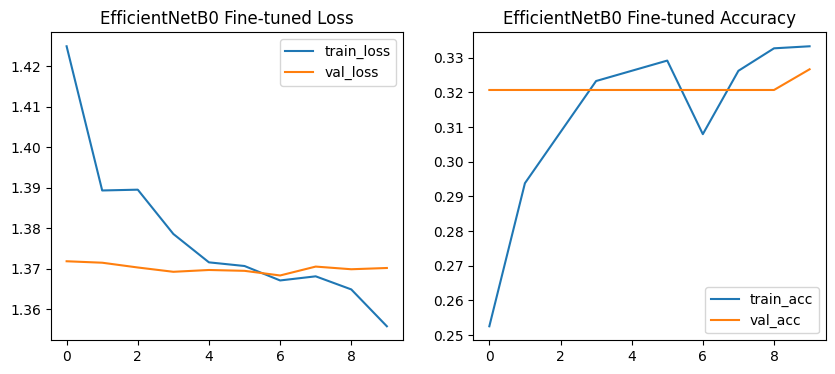

In [ ]:
# ========================================
# STEP 10: Evaluation
# ========================================
def plot_history(history, title="Model Training"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend(); plt.title(title+" Loss")

    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.legend(); plt.title(title+" Accuracy")
    plt.show()

plot_history(history_custom, "Custom CNN")
plot_history(history_tl, "EfficientNetB0 Initial")
plot_history(history_tl_fine, "EfficientNetB0 Fine-tuned")


8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 11s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


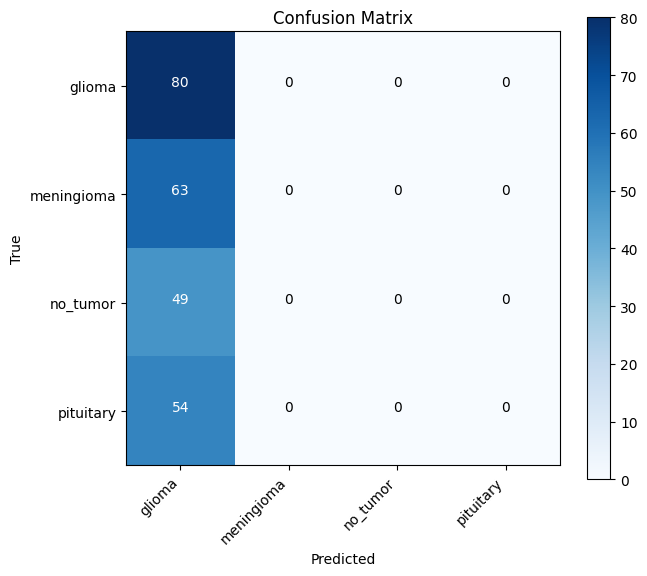

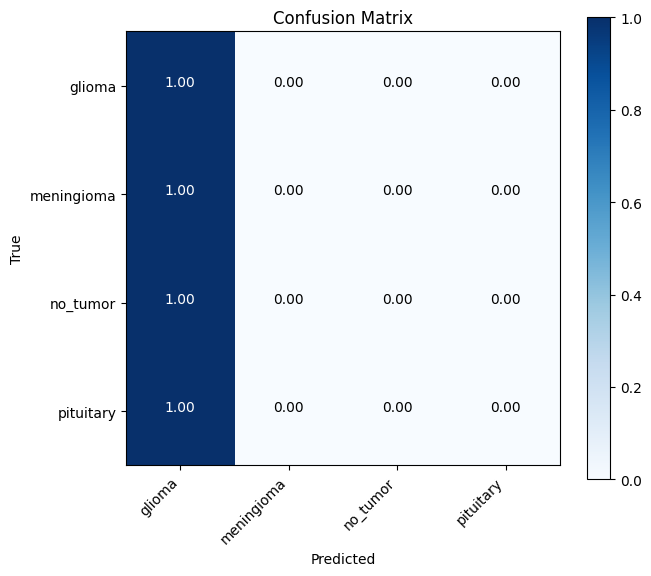

In [ ]:
# ========================================
# STEP 11: Test Set Performance
# ========================================
best_model = tf.keras.models.load_model("tl_effnetb0_final.h5", compile=False)

preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

idx_to_class = {v:k for k,v in class_indices.items()}

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(idx_to_class.values())))

cm = confusion_matrix(y_true, y_pred)

def plot_cm(cm, classes, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]:.2f}" if normalize else cm[i,j],
                 ha="center", color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

plot_cm(cm, classes=list(idx_to_class.values()), normalize=False)
plot_cm(cm, classes=list(idx_to_class.values()), normalize=True)


In [ ]:
# # ========================================
# # STEP 12: Save Models to Drive
# # ========================================
# !cp custom_cnn_final.h5 /content/drive/MyDrive/
# !cp tl_effnetb0_final.h5 /content/drive/MyDrive/
# !cp class_indices.json /content/drive/MyDrive/


In [ ]:
# # ========================================
# # STEP 13: Streamlit App (app.py)
# # Run separately in terminal: streamlit run app.py
# # ========================================
# import streamlit as st
# from PIL import Image
# import numpy as np
# import tensorflow as tf
# import json

# st.title("Brain MRI Tumor Classifier")

# @st.cache_resource
# def load_model_and_mapping(model_path="tl_effnetb0_final.h5", mapping_path="class_indices.json"):
#     model = tf.keras.models.load_model(model_path, compile=False)
#     with open(mapping_path, "r") as f:
#         class_indices = json.load(f)
#     idx_to_class = {int(v):k for k,v in class_indices.items()}
#     return model, idx_to_class

# model, idx_to_class = load_model_and_mapping()

# uploaded_file = st.file_uploader("Upload MRI", type=['jpg','jpeg','png'])
# if uploaded_file:
#     img = Image.open(uploaded_file).convert("RGB")
#     st.image(img, caption="Uploaded", use_column_width=True)
#     if st.button("Predict"):
#         img_resized = img.resize((224,224))
#         x = np.array(img_resized)/255.0
#         x = np.expand_dims(x, axis=0)
#         preds = model.predict(x)[0]
#         top_idx = int(np.argmax(preds))
#         st.write("Prediction:", idx_to_class[top_idx])
#         st.write("Confidence:", float(preds[top_idx]))
#         st.json({idx_to_class[i]: float(preds[i]) for i in range(len(preds))})


2025-09-10 15:07:11.285 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.579 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-10 15:07:11.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.584 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-10 15:07:11.585 Thread 'MainThread': mi